In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xarray as xr


In [5]:
N = 1000
time = np.arange(N)  
data_no = np.random.normal(loc=0,scale=1, size=N)  
data_ex = np.random.exponential(scale=1.0, size=N)  


When we use the Pearson coefficient (Which is the normalized covariance), we make some assumptions about the statistical properties of our time series. It must mainly be normal (gaussian distribution), and stationary (statistics do not change in time) and each sample must be independent from the other. <br />
Let's first take a look at normal distribution. Here, I generate two random series with different with gaussian and non-gaussian distribution.

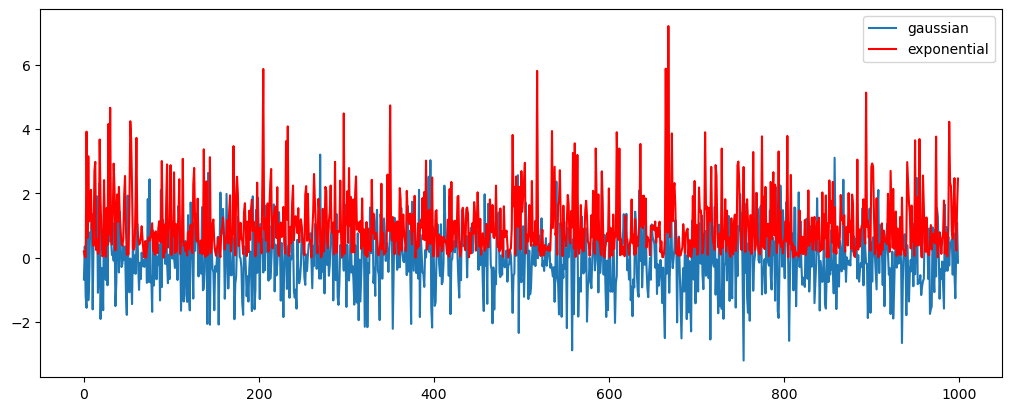

In [6]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(data_no,label='gaussian')
ax.plot(data_ex,label='exponential',color='r')
ax.legend()

Here I used the seaborn histplot function with kde=TRUE to (Kernel Density Estimation, used to create a smoothed curve over the histogram that represents the probability density function). <br />
It is clear they both have different distribution, but I also applied a Shapir-Wilk test to test normality, when p>0.05 (the null hypothesis that the data are normally distributed) then the data is not normally distributed.

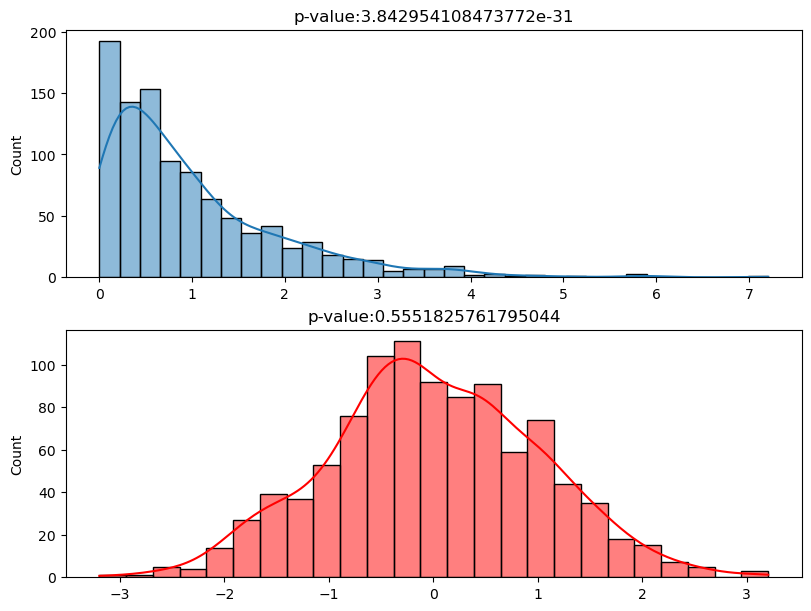

In [10]:
shapiro_ex = stats.shapiro(data_ex)
shapiro_no = stats.shapiro(data_no)



fig, axs = plt.subplots(2,1,figsize=(8,6), constrained_layout=True)
sns.histplot(data_ex,kde=True,ax=axs[0])
axs[0].set_title('p-value:'+ str(shapiro_ex.pvalue))

sns.histplot(data_no,kde=True,ax=axs[1],color='r')
axs[1].set_title('p-value:'+ str(shapiro_no.pvalue));


There is some methods to tranform non-gaussian distributions to gaussian. Here, I used boxcox and it works!

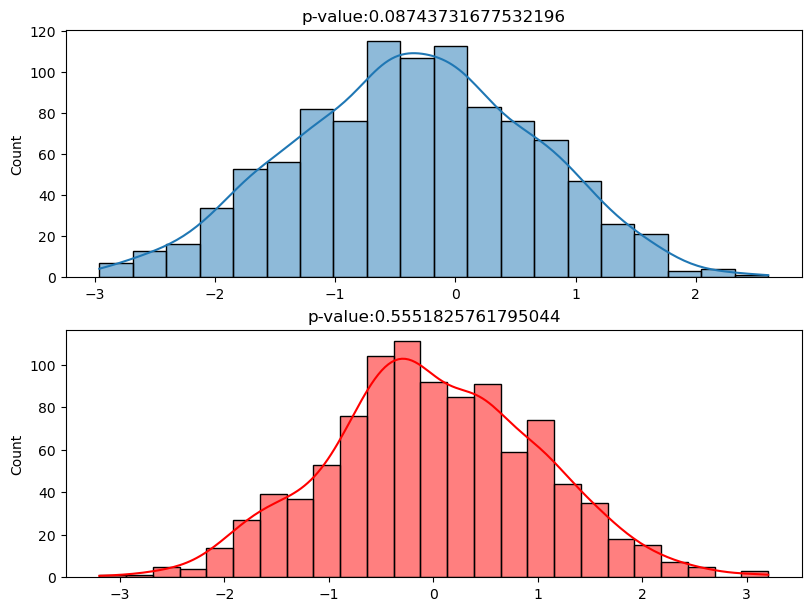

In [22]:
from scipy.stats import boxcox

shapiro_ex = stats.shapiro(boxcox(data_ex)[0])
shapiro_no = stats.shapiro(data_no)



fig, axs = plt.subplots(2,1,figsize=(8,6), constrained_layout=True)
sns.histplot(boxcox(data_ex)[0],kde=True,ax=axs[0])
axs[0].set_title('p-value:'+ str(shapiro_ex.pvalue))

sns.histplot(data_no,kde=True,ax=axs[1],color='r')
axs[1].set_title('p-value:'+ str(shapiro_no.pvalue));

In [239]:
np.var(data)

0.5

In [243]:
np.sum((data-np.mean(data))**2)/(len(data)-1). If the process is stationary, the properties does not change, and we can take var with N and it would be the same value

0.5005005005005005